Notebook for the augmented model, when having a discrete-time model and augments it with disturbances

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from Modified_FourTank_parameters import p

import numpy as np
from scipy.linalg import expm
from utils_KalmanFilters import DynamicKalmanFilter, StaticKalmanFilter
import matplotlib.pyplot as plt
from utils_Modified_FourTank_functions import (sim22, find_equilibrium, linearize_system, Modified_FourTankSystem, FourTankSystemSensor, 
                                            discretize_system, steady_state)
from utils_functions import FourTankSystemSensor

np.random.seed(0)

In [3]:
x0 = np.array([0, 0, 0, 0])  # Initial states
u0 = np.array([300,300])
d0 = np.array([100,100])

dt = 10
ts = np.arange(0,30*60+dt,dt)
N = len(ts)  # number of intervals
nx = len(x0)
F1 = np.ones_like(ts)*300
F2 = np.ones_like(ts)*300
F3 = np.ones_like(ts)*100
F4 = np.ones_like(ts)*100
u = np.array([F1,F2])
d = np.array([F3,F4])

xs = find_equilibrium(Modified_FourTankSystem, np.array([10000, 10000, 10000, 10000]), np.array([300, 300]), np.array([100, 100]), p)
Ac, Bc, Bdc, Cc, Dc = linearize_system(Modified_FourTankSystem, FourTankSystemSensor, xs, np.array([300, 300]), np.array([100, 100]), p)

#combine u and d
Bc = np.block([Bc, Bdc])
Dc = np.zeros((2,4)) #this is zero in our case

# #discretize 
_, A, B, C, D = discretize_system(Ac,Bc,Cc,Dc, Ts=dt)   
Bu = B[:,:2]
Bd = B[:,2:] 
    
xs, us, ys, ds = steady_state(Modified_FourTankSystem, np.array([10000, 10000, 10000, 10000]), np.array([300, 300]), np.array([100, 100]),p)

print(f'''
xs: {xs}
us: {us}
ys: {ys}
ds: {ds}''')

xs = xs.squeeze()
ys = ys[:2,None]
us = np.tile(us, (1, 361)) 
ds = np.tile(ds, (1, 361)) 

u =us
times = [0,240]
vals = [[300,300],[500,300]]
u = []
for t in ts:
    idx = np.searchsorted(times, t, side="right") - 1
    idx = np.clip(idx, 0, len(vals) - 1)
    
    u.append(vals[idx])        
u = np.array(u).T

x, y, z, T_all, X_all, H_all = sim22(ts, xs, u, d, p, d_noise_level=10, v_noise_level=2, plot=False)


xs: [[22156.52909274]
 [19068.95935971]
 [10086.06114759]
 [ 9034.35770667]]
us: [[300]
 [300]]
ys: [58.20183618 50.19968565 25.52116508 24.14956142]
ds: [[100]
 [100]]


In [4]:
def augmented_matrices(A, Bd, B, C, Cd = np.zeros((2,2))):
    nx, nd = Bd.shape
    
    A_aug = np.block([[A, Bd],[np.zeros((nd,nx)), np.identity(nd)]])
    B_aug = np.block([[B], [np.zeros((nd,nd))]])
    C_aug = np.block([C, Cd])
    
    return A_aug, B_aug, C_aug

A_aug, B_aug, C_aug = augmented_matrices(A, Bd, Bu, C)

nx = A.shape[0]
nd = Bd.shape[1]
Qd = np.diag(np.array([0.01, 0.01])**2)
Qx = np.diag([1, 1, 1, 1])
Q_aug = np.block([
    [Qx, np.zeros((nx, nd))],
    [np.zeros((nd, nx)), Qd]
])


#Noise matrices
G = np.eye(6)

Rww = Q_aug*1e-4
Rvv = np.eye(2)*1e-6

Rwv = np.zeros((6,2))

x_aug_ss = np.vstack([xs[:,None],ds[:,0,None]]).squeeze()
x_aug = np.vstack([x0[:,None], d[:,0,None]]).squeeze()


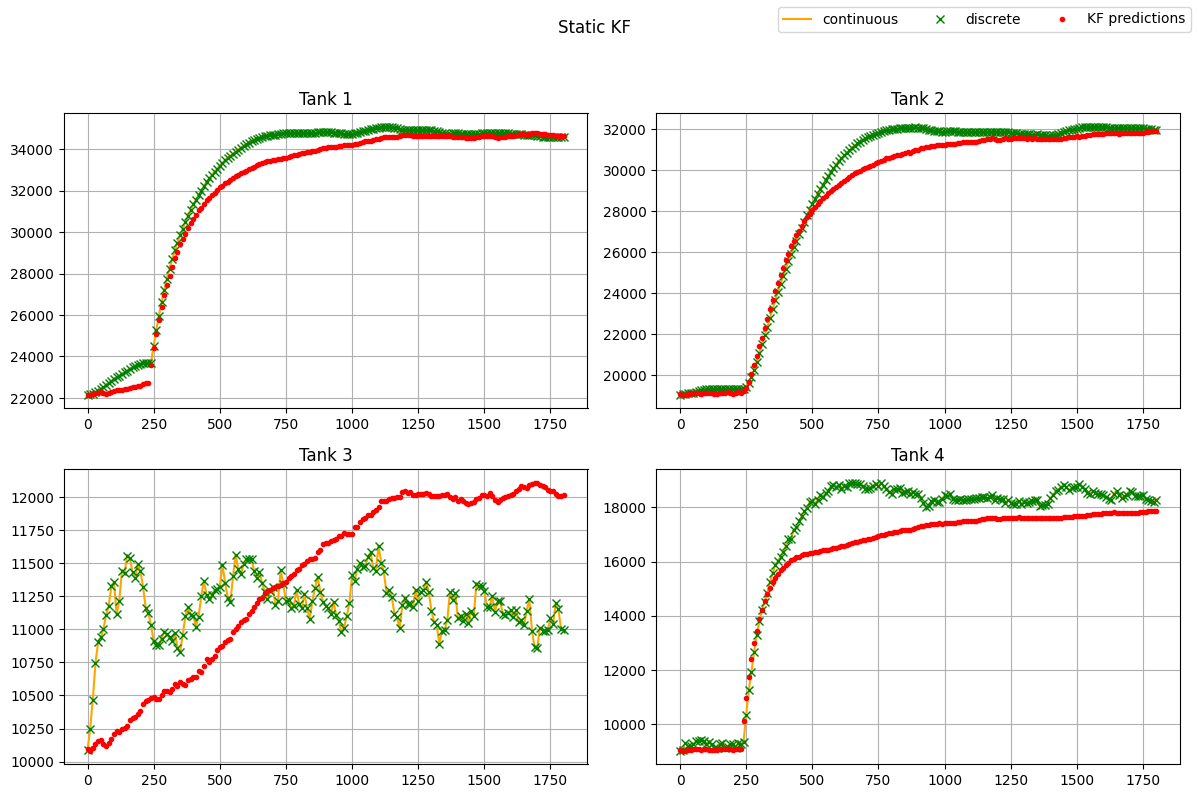

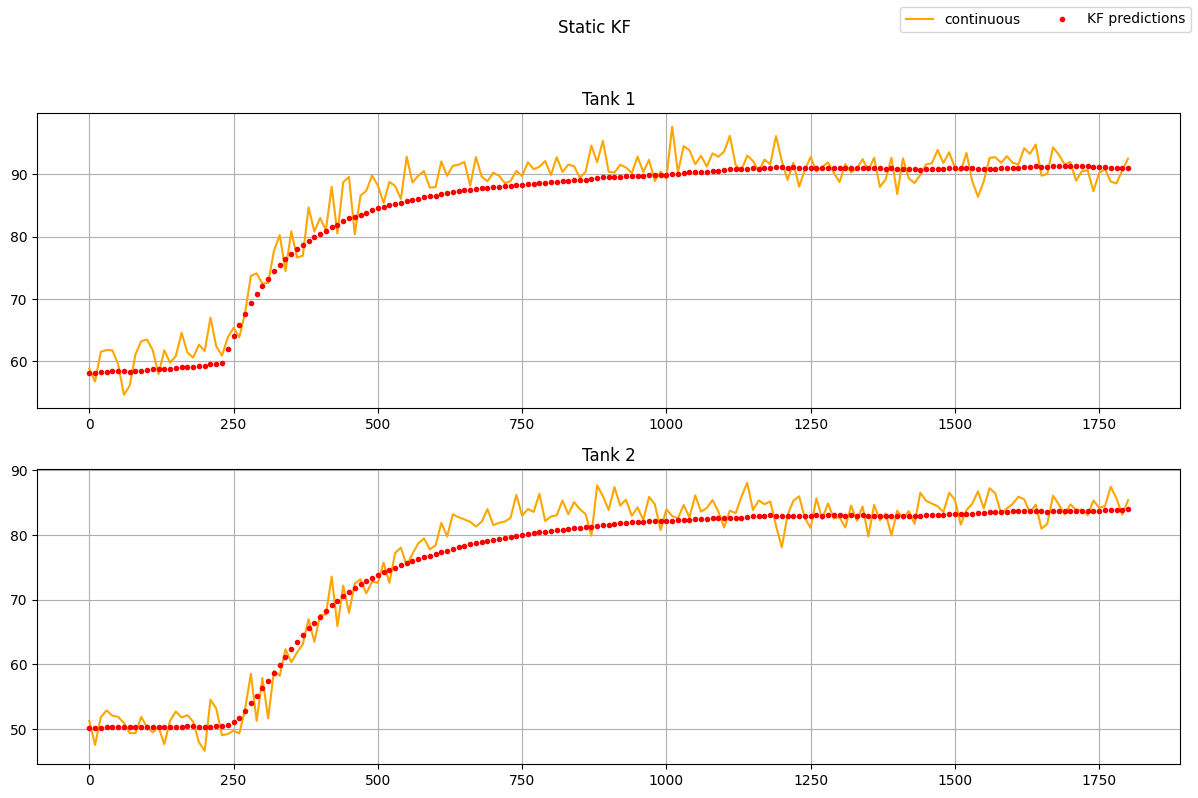

In [5]:
staticKF = StaticKalmanFilter(A_aug,B_aug, C_aug ,G,Rww,Rvv,Rwv,P0=np.eye(6)*np.array([1,1,1,1,0,0]), x0=x_aug_ss-x_aug_ss)

# #KF predictions
predictions = []
ypredictions = []
for uk, yk in zip(u.T,y.T):
    uk = uk[:,None]-us[:,0,None]
    yk = yk[:2,None]-ys
    
    staticKF.update(yk, uk) #update to estimate x[k|k]
    xhat, yhat = staticKF.x, staticKF.y
    predictions.append(xhat+x_aug_ss[:,None])
    ypredictions.append(yhat+ys)
predictions = np.array(predictions).squeeze()
static_ypredictions = np.array(ypredictions).squeeze()

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Static KF')
for i in range(4):
    ax = axs[i//2, i%2]     # select subplot

    ax.plot(T_all, X_all[:,i], label='continuous', color='orange')
    ax.plot(ts, x[i,:], 'x', label='discrete', color='green')
    ax.plot(ts, predictions[:,i], 'r.', label='KF predictions')

    ax.set_title(f"Tank {i+1}")
    # ax.set_ylim(0, None)
    ax.grid(True)
    
# Only one legend for all subplots:
handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

fig, axs = plt.subplots(2, 1, figsize=(12, 8))
fig.suptitle('Static KF')
for i in range(2):
    ax = axs[i]

    ax.plot(ts, y[i,:], label='continuous', color='orange')
    ax.plot(ts, static_ypredictions[:,i], 'r.', label='KF predictions')

    ax.set_title(f"Tank {i+1}")
    # ax.set_ylim(0, None)
    ax.grid(True)
    
# Only one legend for all subplots:
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

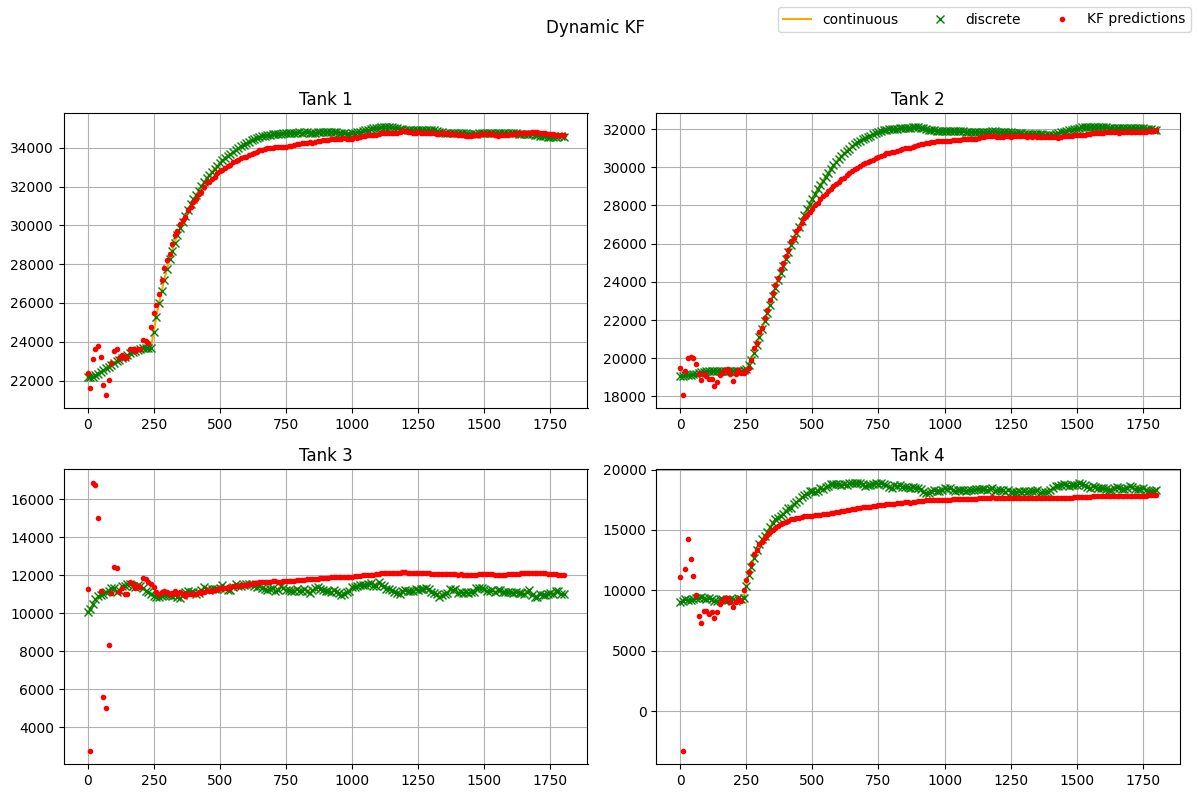

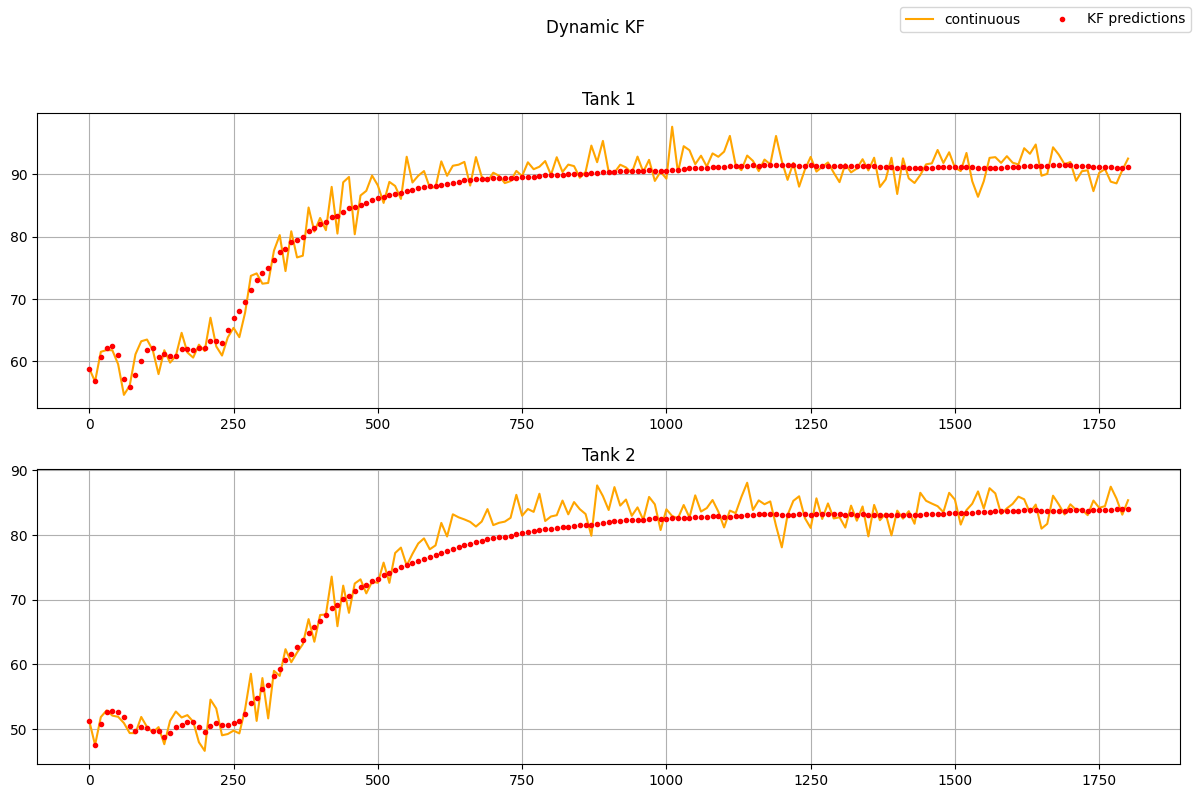

In [6]:
dynamicKF = DynamicKalmanFilter(A_aug,B_aug, C_aug ,G,Rww,Rvv,Rwv,P0=np.eye(6)*10, x0=x_aug_ss-x_aug_ss)

# #KF predictions
predictions = []
ypredictions = []
for uk, yk in zip(u.T,y.T):
    uk = uk[:,None]-us[:,0,None]
    yk = yk[:2,None]-ys

    dynamicKF.update(yk, uk) #update to estimate x[k|k]
    xhat, yhat = dynamicKF.x, dynamicKF.y
    
    predictions.append(xhat+x_aug_ss[:,None])
    ypredictions.append(yhat+ys)
predictions = np.array(predictions).squeeze()
dynamic_ypredictions = np.array(ypredictions).squeeze()

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Dynamic KF')
for i in range(4):
    ax = axs[i//2, i%2]     # select subplot

    ax.plot(T_all, X_all[:,i], label='continuous', color='orange')
    ax.plot(ts, x[i,:], 'x', label='discrete', color='green')
    ax.plot(ts, predictions[:,i], 'r.', label='KF predictions')

    ax.set_title(f"Tank {i+1}")
    # ax.set_ylim(0, None)
    ax.grid(True)
    
# Only one legend for all subplots:
handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

fig, axs = plt.subplots(2, 1, figsize=(12, 8))
fig.suptitle('Dynamic KF')
for i in range(2):
    ax = axs[i]

    ax.plot(ts, y[i,:], label='continuous', color='orange')
    ax.plot(ts, dynamic_ypredictions[:,i], 'r.', label='KF predictions')

    ax.set_title(f"Tank {i+1}")
    # ax.set_ylim(0, None)
    ax.grid(True)
    
# Only one legend for all subplots:
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

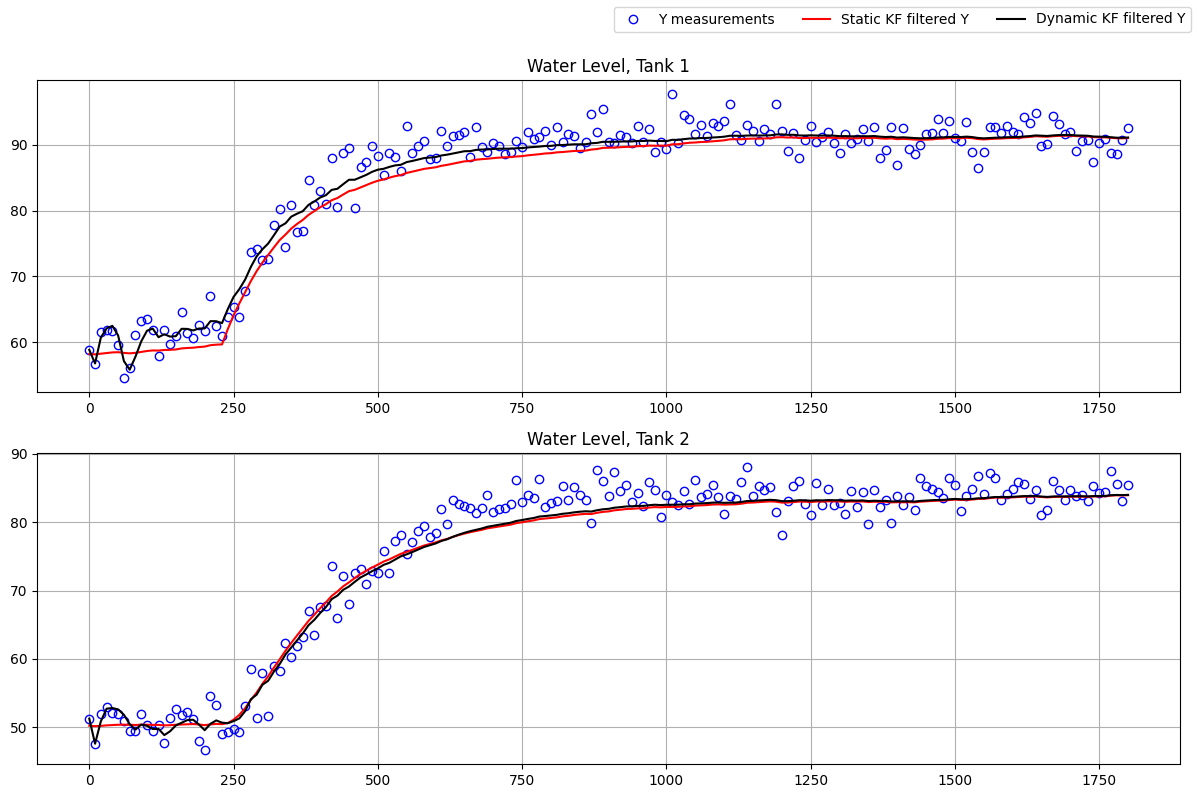

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
for i in range(2):
    ax = axs[i]

    ax.plot(ts, y.T[:,i], 'o', label='Y measurements', color='blue', markerfacecolor='none')
    ax.plot(ts, static_ypredictions[:,i], label='Static KF filtered Y', color = 'red')
    ax.plot(ts, dynamic_ypredictions[:,i], label='Dynamic KF filtered Y', color = 'black')

    ax.set_title(f"Water Level, Tank {i+1}")
    # ax.set_ylim(0, None)
    ax.grid(True)
    
# Only one legend for all subplots:
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from parameters import p

import numpy as np
from scipy.linalg import expm
from utils_KalmanFilters import DynamicKalmanFilter, StaticKalmanFilter
import matplotlib.pyplot as plt
from utils_Modified_FourTank_functions import (sim22, find_equilibrium, linearize_system, Modified_FourTankSystem, FourTankSystemSensor, 
                                            discretize_system, steady_state)
from utils_functions import FourTankSystemSensor

np.random.seed(0)

# Kalman Filter State Estimation